# Khám phá các phân khúc bán phím trên thị trường Việt Nam

## Import thư viện

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import csv

## Đọc file

In [2]:
dt = pd.read_csv("clean_data.csv")
dt.info()
dt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tên SP        575 non-null    object
 1   Nhà sản xuất  575 non-null    object
 2   Model         575 non-null    object
 3   Kết nối       575 non-null    object
 4   Kích thước    575 non-null    object
 5   Loại switch   575 non-null    object
 6   Giá(đ)        575 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 31.6+ KB


,Tên SP,Nhà sản xuất,Model,Kết nối,Kích thước,Loại switch,Giá(đ)
0,Bàn phím Gaming ASUS ROG AZOTH,Asus,0,có dây,326,0,6099000
1,Bàn phím Gaming Asus ROG Azoth NX SM Black,Asus,90MP031B-BKUA01,có dây,326,Đang cập nhật,5999000
2,Bàn phím Gaming ASUS ROG AZOTH NX RED,Asus,0,có dây,326,0,5999000
3,Bàn phím cơ Asus ROG Falchion Blue switch 90MP...,Asus,ROG Falchion,không dây,305,Blue,1599000
4,Bàn phím Gaming Asus ROG Strix Scope II NX SM,Asus,90MP036A-BKUA00,có dây,436,Đang cập nhật,3199000


# raw_data

In [ ]:
global csv_writer
csv_file = open('raw_data.csv', 'w',newline='',encoding='UTF-16')
csv_writer = csv.writer(csv_file,delimiter='\t')
csv_writer.writerow(['Tên SP','Nhà sản xuất','Model','Kết nối','Kích thước','Loại switch','Giá(đ)'])
page = 1
count =1
url = 'https://hacom.vn/ban-phim-may-tinh/'+str(page)+'/'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 Edg/123.0.0.0",
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "Accept-Language": "en-US,en;q=0.5", "Accept-Encoding": "gzip, deflate", 
            "Upgrade-Insecure-Requests": "1"
            }

# request the url text and create BeautifulSoup object to parse html
req = requests.Session()
source_code = req.get(url,headers=headers)
plain_text = source_code.text
soup = BeautifulSoup(plain_text, "lxml")

Tìm kiếm trong từng sản phẩm link dẫn đến sản phẩm đó

In [ ]:
for link in tqdm(soup.findAll('div', {'class': 'p-img'})):

            keyboard = link.a
            print(keyboard.get('href'))
            href = 'https://hacom.vn/' + keyboard.get('href')

            

In [ ]:
def get_item(item_url, count):

    #same procedure as before, request keyboard url and create a BeuatifulSoup object
    headers = {"User-Agent":  "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 Edg/123.0.0.0",
               "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
               "Accept-Language": "en-US,en;q=0.5", "Accept-Encoding": "UTF-8,gzip, deflate", "DNT": "1",
               "Connection": "close", "Upgrade-Insecure-Requests": "1"}
    source_code = requests.get(item_url, headers=headers)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text, "lxml")
    #print(soup.prettify())


    try:
        name = soup.find('div', {'class': 'product_detail-header'}).h1.text.strip()
        #print(name)
    except:
        name = None
    try:
        price_tag = soup.find('strong', class_='giakm')
        price = int(price_tag['data-price'])  
        
    except:
        price = None

   # csv_writer.writerow([name])

    rows = soup.find('div',{'class': 'bang-tskt'}).find_all('tr')

    # Khởi tạo danh sách để chứa thông tin từng dòng
    info_list = []
    brand= model =connectType = size= switch= ''

    # Lặp qua từng dòng và lưu vào danh sách
    for row in rows:
        cells = row.find_all('td')
        if len(cells) == 2:
            key = cells[0].text.strip()
            if 'sản xuất' in key or 'Thương hiệu' in key:
                brand = cells[1].text.strip()
            elif 'Model' in key or 'Mã sản phảm' in key:
                model= cells[1].text.strip()
            elif 'Kết nối' in key:
                connectType = cells[1].text.strip()
            elif 'Kích thước' in key or 'Kích cỡ' in key:
                size = cells[1].text.strip()
            elif 'Switch' in key or 'Loại switch' in key:
                switch = cells[1].text.strip()

# clean data

In [ ]:
def replace_missing_manufacturer(df):
    # Thay đổi giá trị 'Đang cập nhật' thành khoảng trắng
    df['Nhà sản xuất'] = df['Nhà sản xuất'].replace('Đang cập nhật', '')

    # Tạo một danh sách chứa tất cả các nhà sản xuất đã xuất hiện trong cột "Nhà sản xuất"
    manufacturers = df['Nhà sản xuất'].unique().tolist()
    
    # Duyệt qua từng dòng trong dataframe
    for index, row in df.iterrows():
        product_name = row['Tên SP']
        if isinstance(product_name, str):  # Kiểm tra xem giá trị của product_name có phải là chuỗi không
            # Duyệt qua từng nhà sản xuất đã từng xuất hiện
            for manufacturer in manufacturers:
                if isinstance(manufacturer, str):  # Kiểm tra xem giá trị của manufacturer có phải là chuỗi không
                    # Nếu tên nhà sản xuất có trong tên sản phẩm thì thay thế dữ liệu trống trong cột "Nhà sản xuất"
                    if manufacturer.lower() in product_name.lower():
                        df.at[index, 'Nhà sản xuất'] = manufacturer
                        break  # Sau khi thay thế xong, thoát khỏi vòng lặp
    
    return df


## Lấy dữ liệu cho biến

In [13]:
gt = dt["Giá(đ)"]

kt = dt["Kích thước"]

nsx = dt["Nhà sản xuất"]

kn = dt["Kết nối"]

      

['0' '124 ' '129 ' '132 ' '139' '140 ' '151 ' '193' '265' '270' '285'
 '290' '291' '292 ' '293 ' '30 ' '300' '302' '305' '305 ' '306 ' '310'
 '311' '312' '315 ' '316 ' '32 ' '321' '323' '325 ' '326 ' '327' '327 '
 '330' '333' '333 ' '335' '335 ' '352 ' '354 ' '355 ' '356' '356 ' '358'
 '360' '360 ' '362' '362 ' '365' '365 ' '368' '370' '373' '375' '377 '
 '380' '380 ' '382 ' '387' '390' '410' '430' '430 ' '433' '434' '435'
 '435 ' '436' '436 ' '437' '438' '438 ' '439 ' '440' '440 ' '441' '442'
 '442 ' '444' '444 ' '445' '446' '455' '455\xa0' '460' '471']


## Trực quan hóa

### Phân bố sản phẩm theo mức tiền

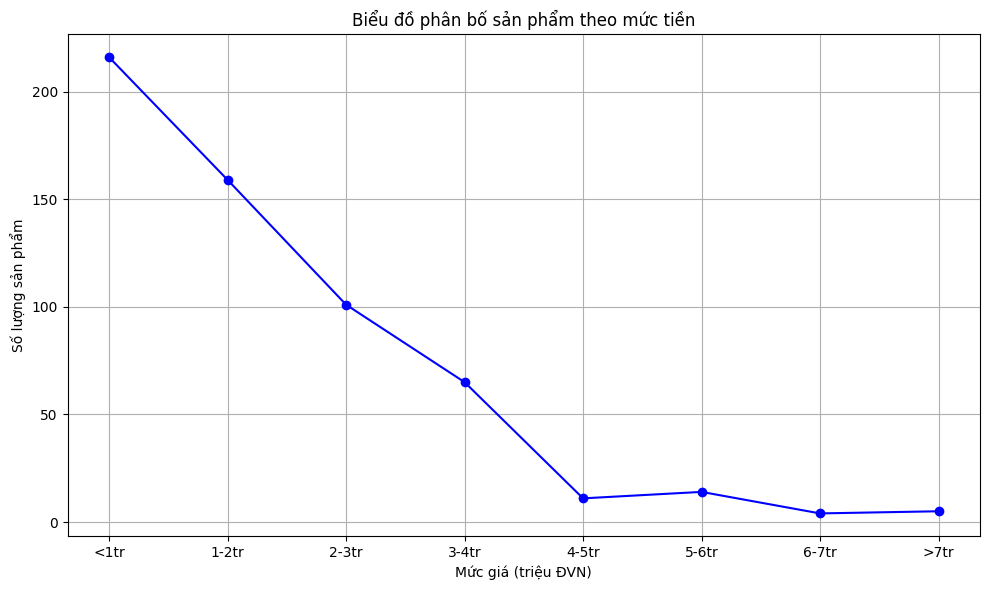

In [4]:
bins = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, np.inf] 
labels = ['<1tr', '1-2tr', '2-3tr', '3-4tr', '4-5tr', '5-6tr', '6-7tr', '>7tr']
dt['Giá phân loại'] = pd.cut(gt, bins=bins, labels=labels, right=False)

count_by_price = dt['Giá phân loại'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
count_by_price.plot(kind='line', marker='o', color='b')
plt.title('Biểu đồ phân bố sản phẩm theo mức tiền')
plt.xlabel('Mức giá (triệu ĐVN)')
plt.ylabel('Số lượng sản phẩm')
plt.grid(True)
plt.tight_layout()
plt.show()

### Phân bố theo 3 phân khúc giá

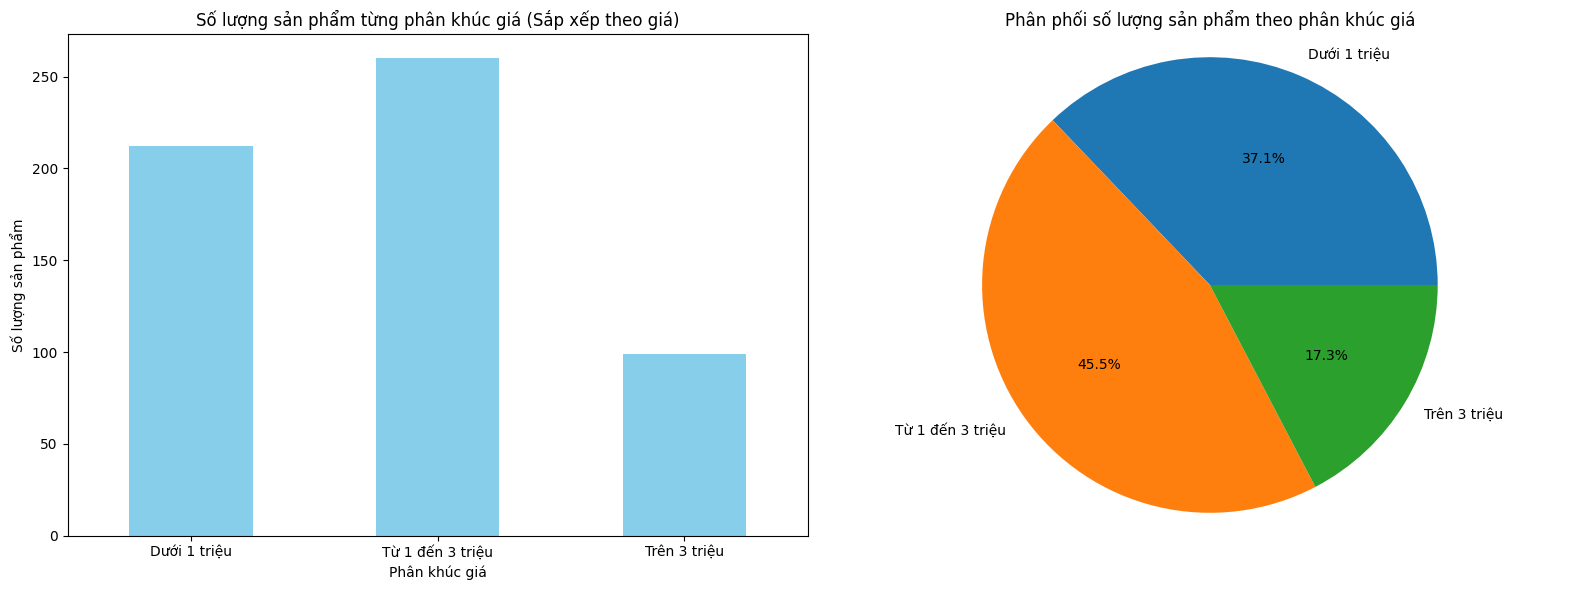

In [12]:
data = dt[(dt['Giá(đ)'] != 0) & (dt['Nhà sản xuất'] != '0')]

data.loc[:,'Price Segment'] = pd.cut(data['Giá(đ)'], bins=[0, 1000000, 3000000, float('inf')],
                               labels=['Dưới 1 triệu', 'Từ 1 đến 3 triệu', 'Trên 3 triệu'])
price_segment_counts = data['Price Segment'].value_counts()
price_segment_counts_sorted = price_segment_counts.sort_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
price_segment_counts_sorted.plot(kind='bar', color='skyblue')
plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng sản phẩm')
plt.title('Số lượng sản phẩm từng phân khúc giá (Sắp xếp theo giá)')
plt.xticks(rotation=0)  

plt.subplot(1, 2, 2)
plt.pie(price_segment_counts_sorted, labels=price_segment_counts_sorted.index, autopct='%1.1f%%')
plt.title('Phân phối số lượng sản phẩm theo phân khúc giá')
plt.axis('equal') 

plt.tight_layout()
plt.show()


### Top 5 nhà sản xuất theo từng phân khúc giá

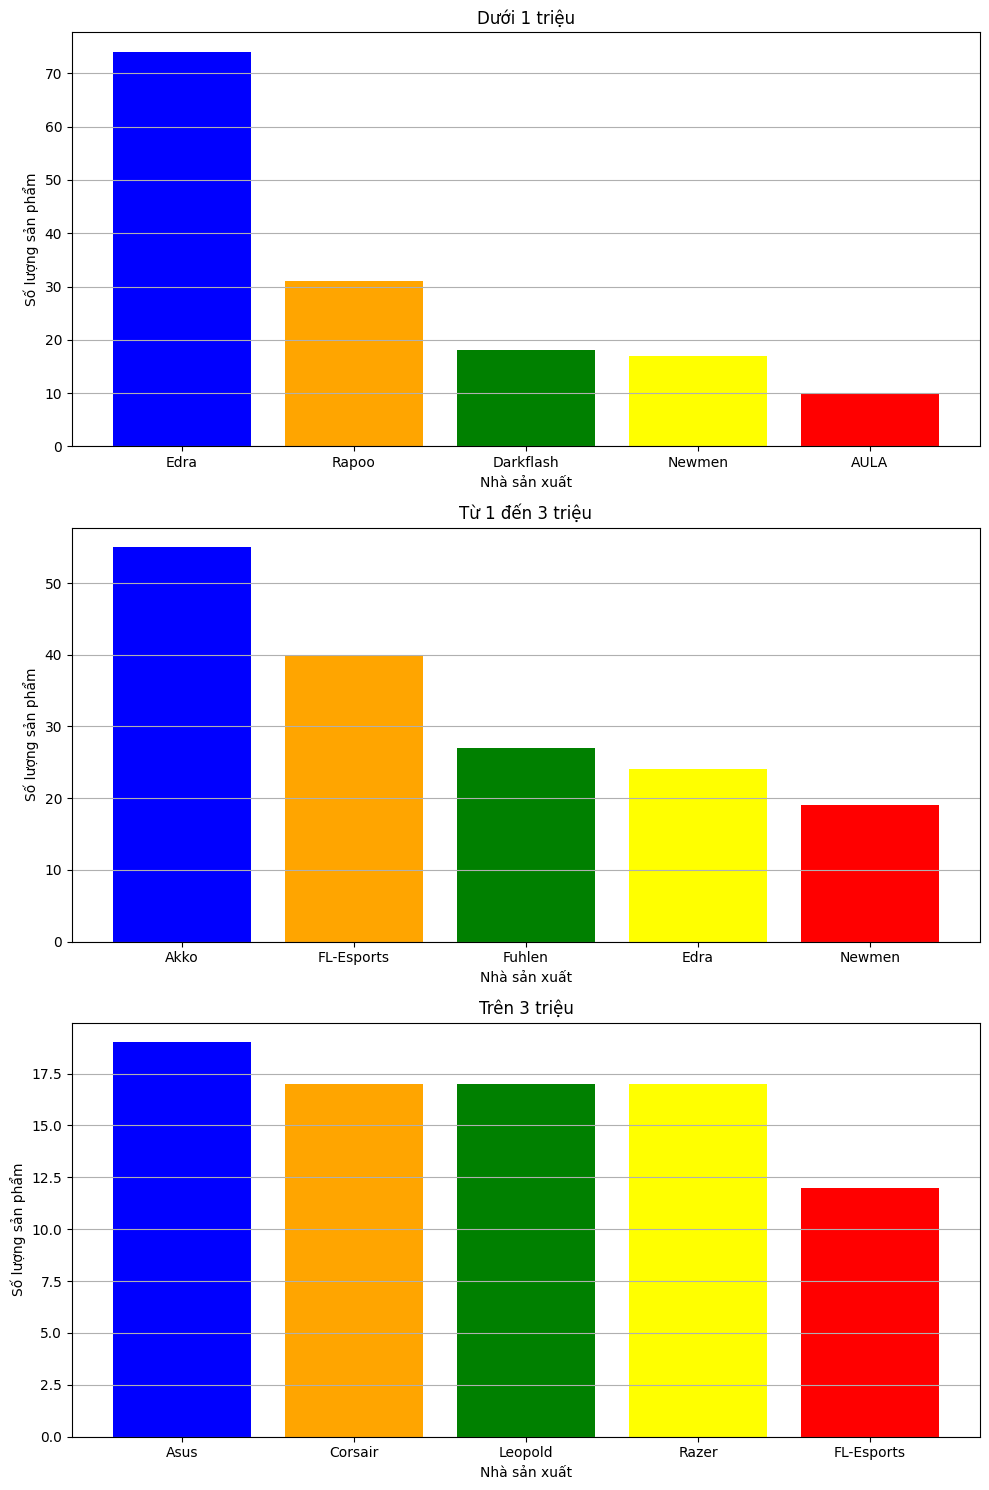

In [6]:
top_3_manufacturers = data.groupby(['Price Segment', 'Nhà sản xuất'], observed=False).size().groupby(level=0, group_keys=False, observed=False).nlargest(5).reset_index(name='Count')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

for i, (segment, segment_data) in enumerate(top_3_manufacturers.groupby('Price Segment', observed=False)):
    ax = axes[i]
    ax.bar(segment_data['Nhà sản xuất'], segment_data['Count'], color=['blue', 'orange', 'green','yellow','red'])
    ax.set_title(segment)
    ax.set_ylabel('Số lượng sản phẩm')
    ax.set_xlabel('Nhà sản xuất')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()


### Phân bố sản phẩm theo mức tiền và cách kết nối

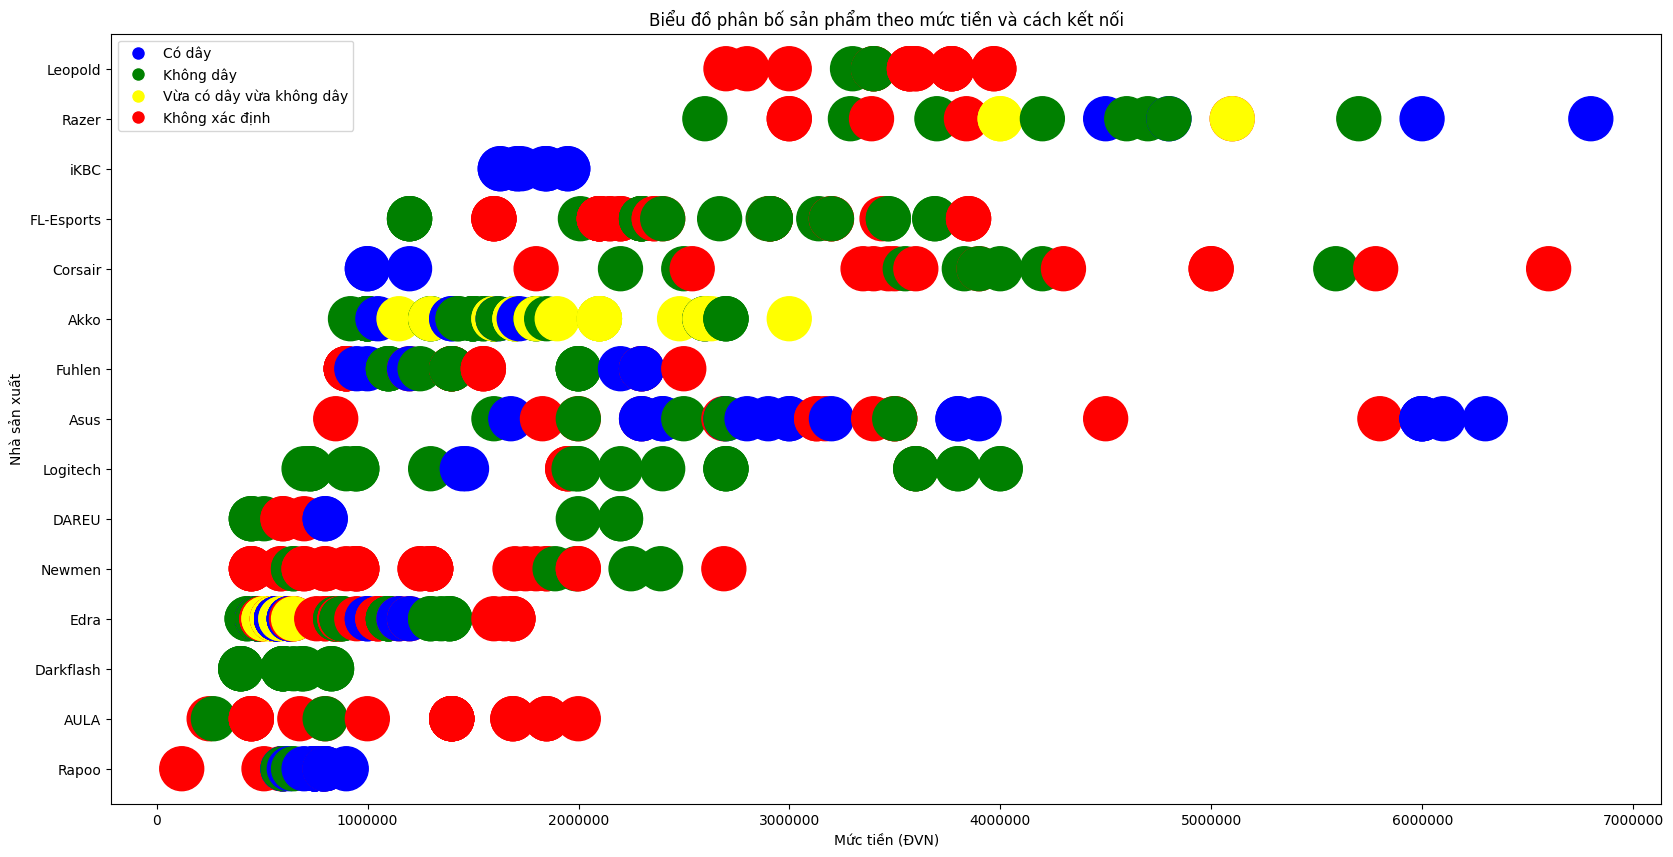

In [7]:
nsx_counts = dt['Nhà sản xuất'].value_counts()
top_15_nsx = nsx_counts.head(15).index.tolist()
dt_filtered = dt[dt['Nhà sản xuất'].isin(top_15_nsx)]

dt_sorted = dt_filtered.sort_values(by=['Giá(đ)', 'Kết nối'])

gt_sorted = dt_sorted["Giá(đ)"]
kn_sorted = dt_sorted["Kết nối"]
colors = ['blue' if k == 'có dây' else 'green' if k == 'không dây' else 'yellow' if k == 'vừa có dây vừa không dây' else 'red' for k in kn_sorted]
plt.figure(figsize=(20,10))
plt.scatter(gt_sorted, dt_sorted['Nhà sản xuất'], c=colors, s=1000)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Có dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Không dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Vừa có dây vừa không dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Không xác định')
])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Biểu đồ phân bố sản phẩm theo mức tiền và cách kết nối')
plt.xlabel('Mức tiền (ĐVN)')
plt.ylabel('Nhà sản xuất')
plt.show()

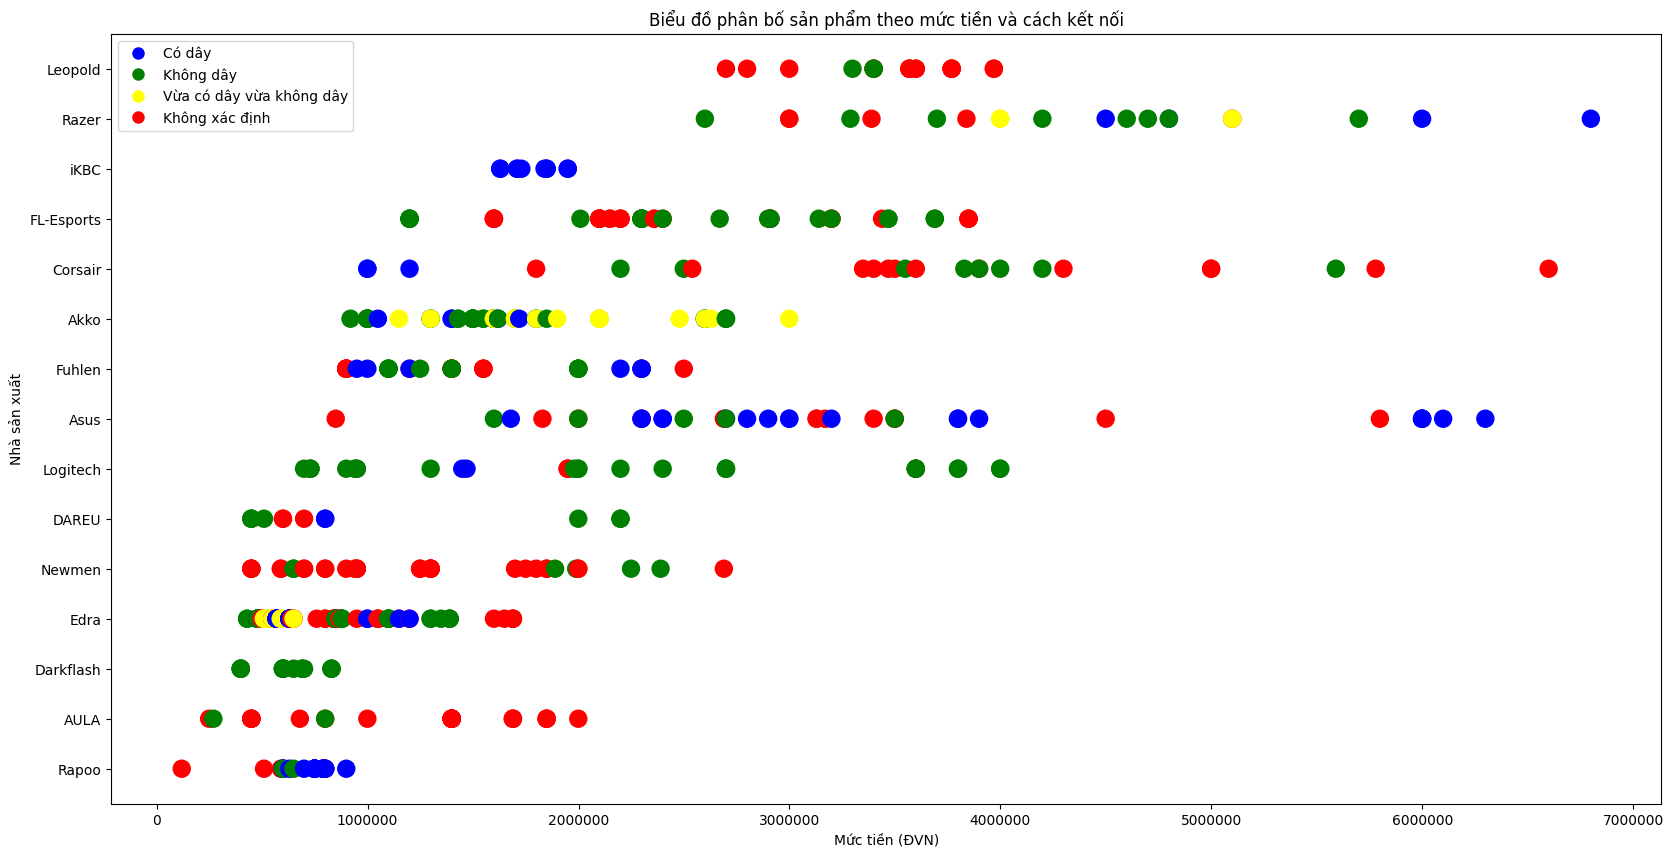

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(gt_sorted, dt_sorted['Nhà sản xuất'], c=colors, s=150)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Có dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Không dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Vừa có dây vừa không dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Không xác định')
])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Biểu đồ phân bố sản phẩm theo mức tiền và cách kết nối')
plt.xlabel('Mức tiền (ĐVN)')
plt.ylabel('Nhà sản xuất')
plt.show()

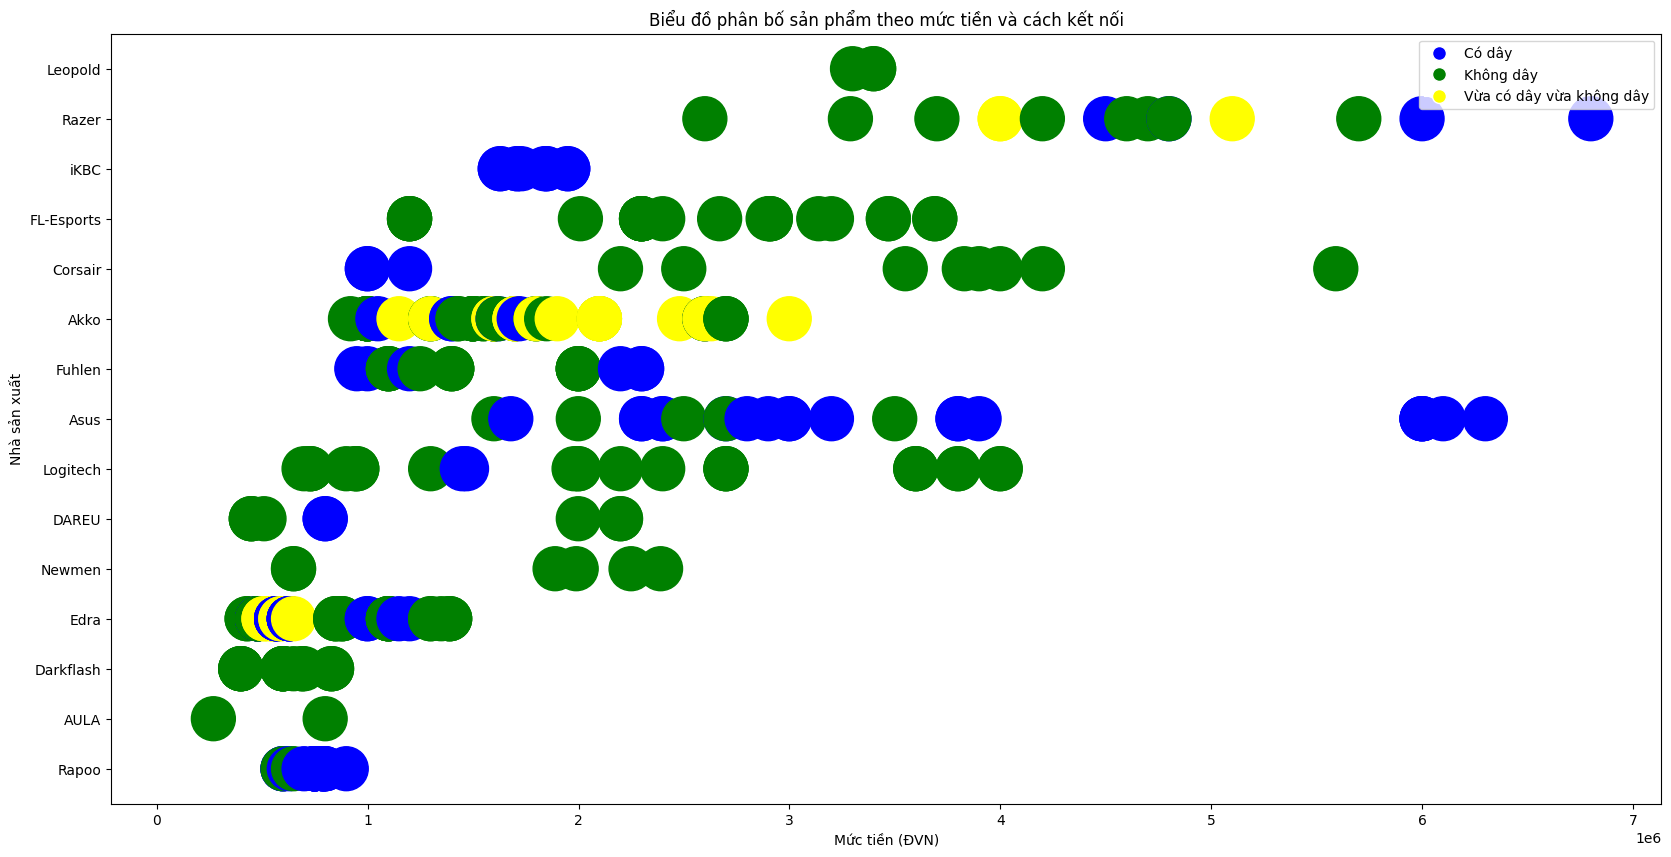

In [9]:
clrs = ['blue' if k == 'có dây' else 'green' if k == 'không dây' else 'yellow' if k == 'vừa có dây vừa không dây' else 'none' for k in kn_sorted]
plt.figure(figsize=(20,10))
plt.scatter(gt_sorted, dt_sorted['Nhà sản xuất'], c=clrs, s=1000)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Có dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Không dây'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Vừa có dây vừa không dây')
])
plt.title('Biểu đồ phân bố sản phẩm theo mức tiền và cách kết nối')
plt.xlabel('Mức tiền (ĐVN)')
plt.ylabel('Nhà sản xuất')
plt.show()

### Phân bố của cách kết nối

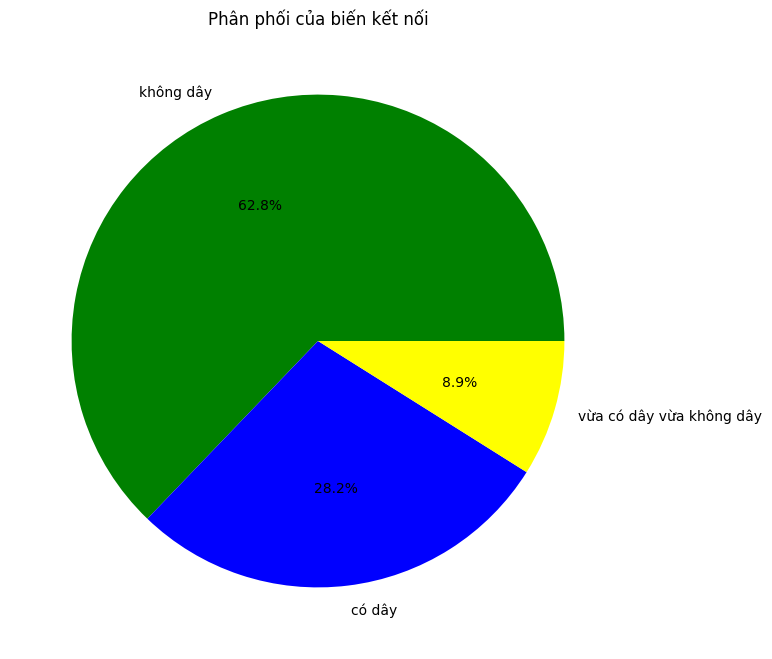

In [10]:
kn = kn[kn != '0']

kn_counts = kn.value_counts()

colors = ['blue' if k == 'có dây' else 'green' if k == 'không dây' else 'yellow' for k in kn_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(kn_counts, labels=kn_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Phân phối của biến kết nối')
plt.show()

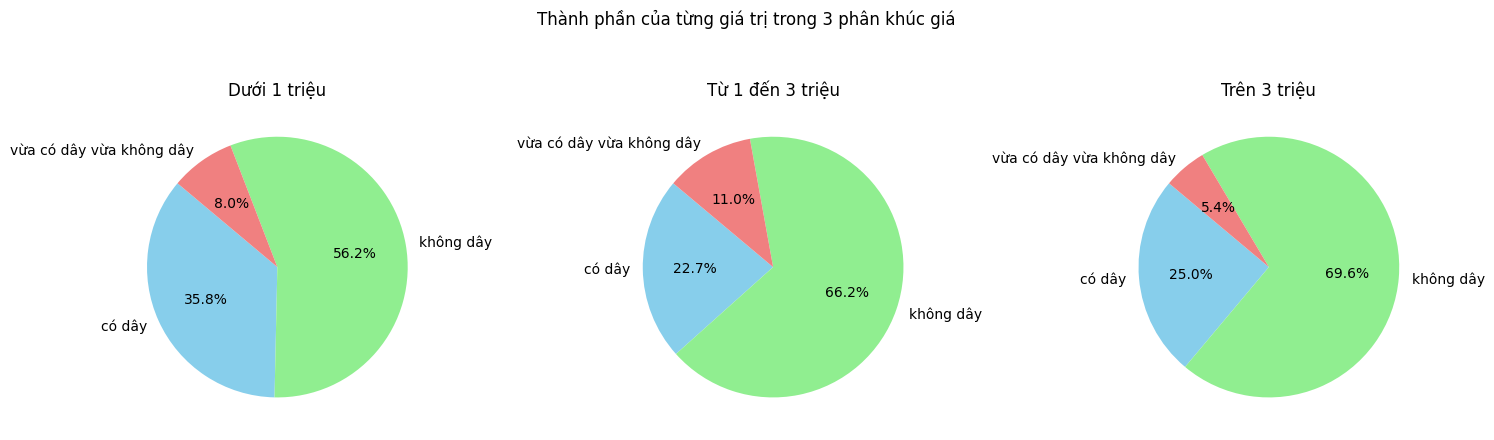

In [11]:
dt['Price Segment'] = pd.cut(dt['Giá(đ)'], bins=[0, 1000000, 3000000, float('inf')], labels=['Dưới 1 triệu', 'Từ 1 đến 3 triệu', 'Trên 3 triệu'])

filtered_data = dt[dt['Kết nối'] != '0']

price_segment_counts = filtered_data.groupby('Price Segment', observed=False)['Kết nối'].value_counts(normalize=True).unstack(fill_value=0)

colors = ['skyblue', 'lightgreen', 'lightcoral']
labels = price_segment_counts.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (segment, counts) in enumerate(price_segment_counts.iterrows()):
    axes[i].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(segment)

plt.suptitle('Thành phần của từng giá trị trong 3 phân khúc giá ')
plt.tight_layout()
plt.show()

### Theo kích thước chiều dài

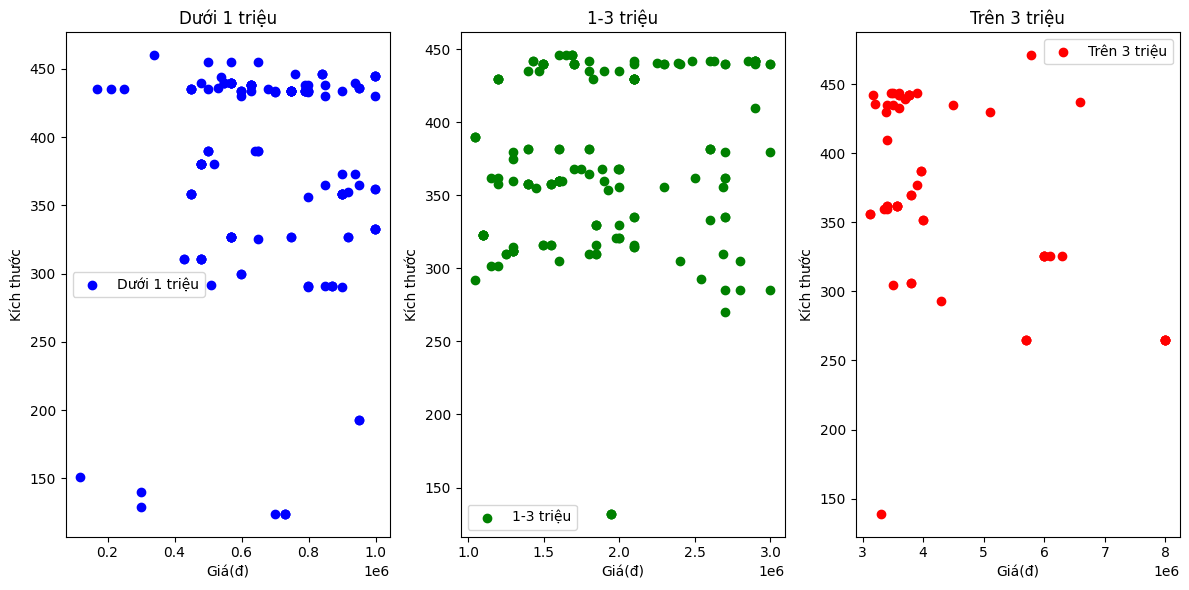

In [15]:
dt['Kích thước'] = dt['Kích thước'].astype(int)

filtered_data = dt[dt['Kích thước'] >= 124]

price_segments = pd.cut(filtered_data['Giá(đ)'], bins=[0, 1000000, 3000000, np.inf], labels=['Dưới 1 triệu', '1-3 triệu', 'Trên 3 triệu'])

under_1m = filtered_data[price_segments == 'Dưới 1 triệu']
between_1_3m = filtered_data[price_segments == '1-3 triệu']
above_3m = filtered_data[price_segments == 'Trên 3 triệu']
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(under_1m['Giá(đ)'], under_1m['Kích thước'], color='blue', label='Dưới 1 triệu')
plt.xlabel('Giá(đ)')
plt.ylabel('Kích thước')
plt.title('Dưới 1 triệu')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(between_1_3m['Giá(đ)'], between_1_3m['Kích thước'], color='green', label='1-3 triệu')
plt.xlabel('Giá(đ)')
plt.ylabel('Kích thước')
plt.title('1-3 triệu')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(above_3m['Giá(đ)'], above_3m['Kích thước'], color='red', label='Trên 3 triệu')
plt.xlabel('Giá(đ)')
plt.ylabel('Kích thước')
plt.title('Trên 3 triệu')
plt.legend()

plt.tight_layout()
plt.show()

# Kết luận

- Số lượng sản phẩm tập trung đa số ở mức giá dưới 3 triệu để đáp ứng nhu cầu của người dùng
- Tùy thị trường mà công ty hướng tới mà ở mỗi phân khúc giá khác nhau mà số lượng sảng phẩm của mỗi công ty cũng có sự khác nhau
- Hiện nay chế độ không dây đang được ưa chuộng vì sự tiện lợi của nó vậy nên ta cũng có thể thấy số lượng sản phẩm không dây nhiều hơn hẳn
- Mức giá càng tăng thì tỉ lệ sản phẩm không dây càng tăng và sản phẩm có dây có xu hứng giảm
- Còn về chiều dài sản phẩm thì tập trung ở mức trên 300 cm
